In [1]:
!pip install opencv-python

In [3]:
#importing all necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Model,Sequential,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

In [4]:
#import os

def load_images_from_folder(foldername):
    images = []
    for filename in os.listdir(foldername):
        img = cv2.imread(os.path.join(foldername,filename))
        if img is not None:
            images.append(img)
    return images
img_list=load_images_from_folder("C:\\Users\\91880\\Desktop\\main p 3\\CASIA2\\Au")

In [5]:
len(img_list[0])

256

In [6]:
data_dir = r'C:\\Users\\91880\\Desktop\\main p 3\\CASIA2\\Au'
train_dir = os.path.join(data_dir)

In [7]:
#class labels
image_type = ['Authenticated','Tampered']

Performing Error level Analysis

In [8]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

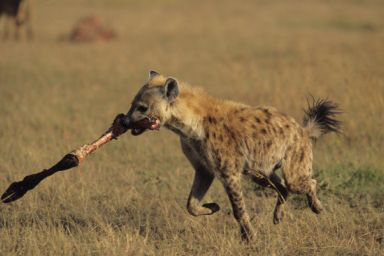

In [9]:
real_image_path = "C:\\Users\\91880\\Desktop\\main p 3\\CASIA2\\Au\\Au_ani_00067.jpg"
Image.open(real_image_path)

ELA converted image

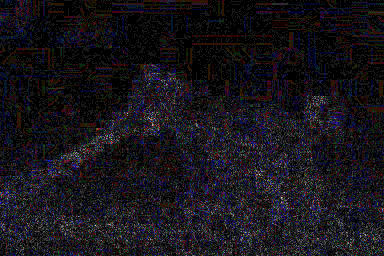

In [10]:
convert_to_ela_image(real_image_path, 85)

Resizing image and converting it for making suitable to model

In [11]:
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten() / 255.0

In [12]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

Getting authenticated images

In [13]:
import random
count = 0
path = 'C:\\Users\\91880\\Desktop\\main p 3\\CASIA2\\Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
#         count+=1
#         if count < 1000:
#             pass
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
        if len(Y) % 2000 == 0:
            print(f'Processing {len(Y)} images')
            break
    if len(Y) % 2000 == 0:
        break

random.shuffle(X)
# X = X[:2100]
# Y = Y[:2100]
print(len(X), len(Y))

Processing 2000 images
2000 2000


In [ ]:
x_t, y_t = [], []

Getting tampered images

In [14]:
path = 'C:\\Users\\91880\\Desktop\\main p 3\\CASIA2\\Tp'
count = 0
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
#         count += 1
#         if count < 1000:
#             pass
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
        if len(Y) % 4000 == 0:
            print(f'Processing {len(Y)} images')
            break
    if len(Y) % 4000 == 0:
        break

print(len(X), len(Y))

Processing 4000 images
4000 4000


In [15]:
au,tp=0,0
for i in Y:
    if(i==1):
        au+=1
    else:
        tp+=1
print(tp,au)

2000 2000


In [16]:
#shuffling of images
from sklearn.utils import shuffle
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

In [17]:
#reshaping the image array
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [18]:
#splitting the dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=42)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3200 3200
800 800


CUSTOM CNN MODEL

In [19]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

model1 = build_model()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

IMPLEMENTED CUSTOM CNN MODEL

In [20]:
def build_model():
    model = Sequential()
    model.add(Conv2D(input_shape=(128,128,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=512,activation="relu"))
    model.add(Dense(units=256,activation="relu"))
    model.add(Dense(units=2, activation="softmax"))

    print(model.summary())
    return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                 

In [21]:
from tensorflow.keras.optimizers import Adam

In [22]:
import tensorflow as tf
from tensorflow.keras.optimizers import legacy

#optimizer for training weights
init_lr = 1e-4
optimizer = legacy.Adam(learning_rate = init_lr, decay = init_lr/50)

In [23]:
#compiling the model
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [24]:
model1.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [25]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=2,verbose=0, mode='auto')

In [26]:
#training the model
batch_size =30
epochs = 10

history = model.fit(
    X_train, Y_train,
    epochs=epochs,

    batch_size = batch_size,
    validation_data=(X_val, Y_val),
    verbose=2, callbacks=[early_stopping])
# ,callbacks=early_stopping
# score = model.evaluate(x_test, y_test)
# print('Test accuracy:', score[1])

Epoch 1/10
107/107 - 712s - loss: 0.4859 - accuracy: 0.7538 - val_loss: 0.3636 - val_accuracy: 0.8612 - 712s/epoch - 7s/step
Epoch 2/10
107/107 - 770s - loss: 0.3785 - accuracy: 0.8425 - val_loss: 0.3979 - val_accuracy: 0.8138 - 770s/epoch - 7s/step
Epoch 3/10
107/107 - 723s - loss: 0.3623 - accuracy: 0.8503 - val_loss: 0.3458 - val_accuracy: 0.8725 - 723s/epoch - 7s/step
Epoch 4/10
107/107 - 725s - loss: 0.3290 - accuracy: 0.8656 - val_loss: 0.3329 - val_accuracy: 0.8737 - 725s/epoch - 7s/step
Epoch 5/10
107/107 - 715s - loss: 0.3346 - accuracy: 0.8609 - val_loss: 0.3317 - val_accuracy: 0.8712 - 715s/epoch - 7s/step
Epoch 6/10
107/107 - 700s - loss: 0.3161 - accuracy: 0.8666 - val_loss: 0.3368 - val_accuracy: 0.8587 - 700s/epoch - 7s/step
Epoch 7/10
107/107 - 722s - loss: 0.3003 - accuracy: 0.8734 - val_loss: 0.3159 - val_accuracy: 0.8750 - 722s/epoch - 7s/step
Epoch 8/10
107/107 - 721s - loss: 0.2835 - accuracy: 0.8891 - val_loss: 0.3615 - val_accuracy: 0.8775 - 721s/epoch - 7s/step


In [27]:
for layer in model.layers:
    weights = layer.get_weights()
    print(weights)

[array([[[[ 1.70879178e-02, -9.38949287e-02,  7.16748312e-02, ...,
          -3.34100761e-02, -7.66255558e-02,  1.55755505e-02],
         [-1.00690452e-02, -7.96763599e-02, -2.70776893e-03, ...,
           2.45060306e-02,  4.48584780e-02,  6.00433946e-02],
         [ 9.91962180e-02,  9.30981785e-02,  9.98365507e-02, ...,
           7.73895085e-02,  7.34660849e-02,  1.87895517e-03]],

        [[ 1.92228034e-02,  7.15150982e-02, -5.71553744e-02, ...,
          -5.90956062e-02, -8.04507807e-02,  1.38625083e-02],
         [-2.70351209e-02, -4.92786244e-02, -5.72757497e-02, ...,
          -7.46441931e-02,  9.05455127e-02,  3.79844122e-02],
         [-3.70803406e-03, -8.39170814e-02, -8.63183755e-03, ...,
           8.89571682e-02,  1.20863095e-02,  9.46201608e-02]],

        [[ 7.30337501e-02, -1.57426356e-03,  1.04698829e-01, ...,
          -8.39877576e-02,  5.48043512e-02, -2.99404957e-03],
         [-8.77499878e-02, -1.80295147e-02, -9.49893072e-02, ...,
          -8.72080401e-02,  4.924

In [29]:
#saving the trained model
model.save("C:\\Users\\91880\\Desktop\\main p 3\\cnn_model.h5")

C:\Users\91880\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
from tensorflow.keras.models import load_model

In [31]:
model = load_model("C:\\Users\\91880\\Desktop\\main p 3\\cnn_model.h5")

In [33]:
from tensorflow.keras.utils import plot_model

In [34]:
plot_model(model=model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


TESTING

In [35]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

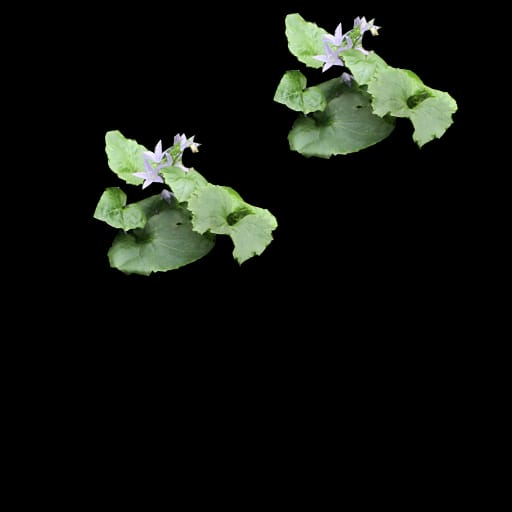

In [ ]:
real_image_path = r"/content/drive/MyDrive/test3.jpg"
Image.open(real_image_path)

In [ ]:
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten() / 255.0

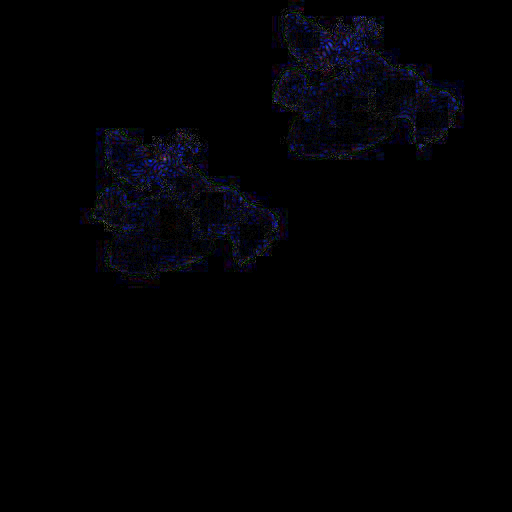

In [ ]:
convert_to_ela_image(real_image_path, 85)

In [ ]:
import numpy as np
path = r"/content/drive/MyDrive/test3.jpg"
x2 = prepare_image(path)
x2 = x2.reshape(-1, 128, 128, 3)

In [ ]:
#TESTING THE IMAGE AND MAKING PREDICTION
arr = model.predict(x2)
print(arr)
res=0
if(arr[0][0]>arr[0][1]):
    res=1
    print("IMAGE IS TAMPERED")
else:
    res=0
    print("IMAGE IS AUTHENTICATED");

1/1 [==============================] - 0s 19ms/step
[[0.9873518  0.01264816]]
IMAGE IS TAMPERED


Localization is required


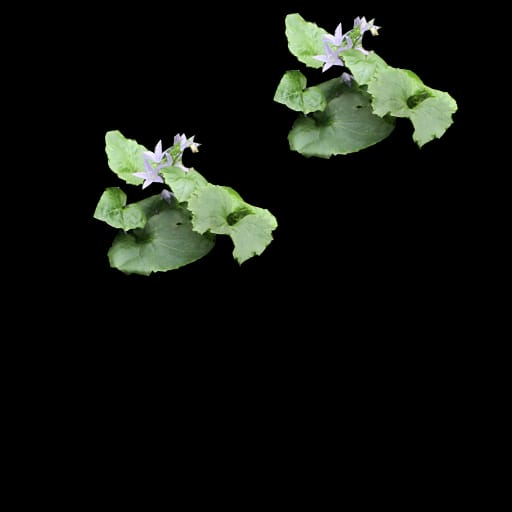

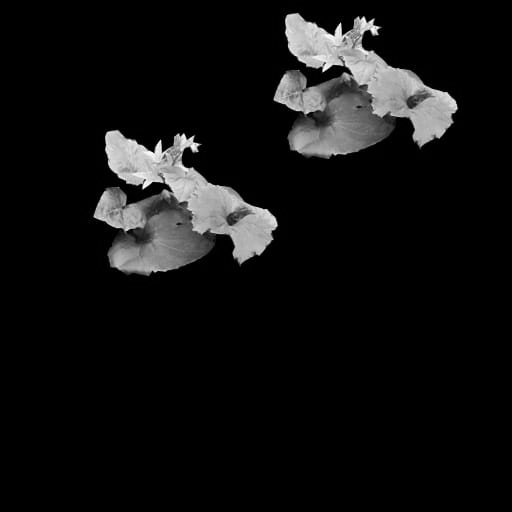

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
94 99 274 271
[(94, 216), (94, 216), (104, 158), (105, 260), (107, 209), (108, 149), (109, 235), (111, 214), (111, 214), (112, 180), (113, 223), (115, 174), (115, 268), (121, 219), (121, 229), (123, 197), (124, 181), (126, 229), (130, 217), (130, 205), (131, 138), (132, 205), (132, 143), (133, 183), (134, 193), (134, 142), (137, 228), (139, 215), (139, 236), (140, 224), (143, 177), (146, 225), (151, 148), (151, 148), (154, 217), (164, 270), (165, 191), (168, 271), (172, 205), (172, 163), (172, 163), (177, 217), (178, 151), (180, 162), (181, 268), (187, 185), (187, 150), (187, 150), (191, 168), (192, 221), (194, 146), (194, 146), (195, 153), (196, 168), (198, 147), (198, 147), (206, 233), (211, 231), (218, 236), (223, 243), (232, 199), (235, 261), (235, 253), (235, 253), (240, 

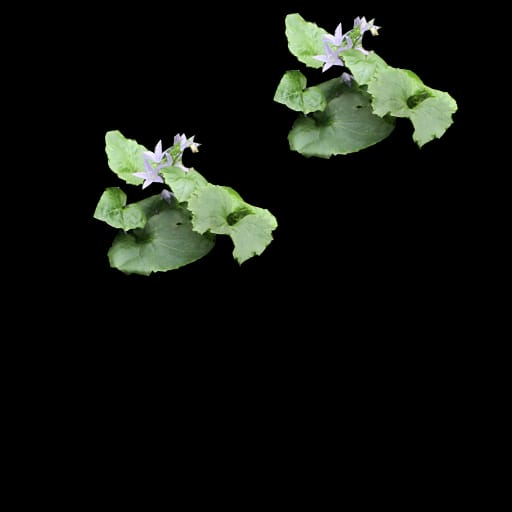

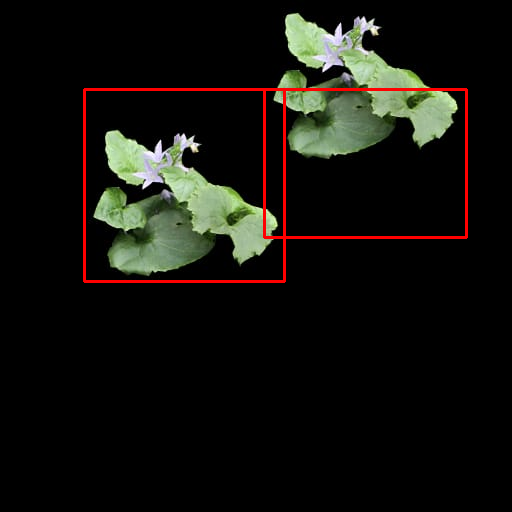

In [ ]:
import sys
import cv2
from sklearn.cluster import DBSCAN
import numpy as np
from google.colab.patches import cv2_imshow
def locateForgery(eps, min_sample, descriptors, key_points, image):
    l1=[]
    l2=[]
    clusters = DBSCAN(eps=eps, min_samples=min_sample).fit(descriptors)
    size = np.unique(clusters.labels_).shape[0] - 1
    forgery = image.copy()
    m=0
    if (size == 0) and (np.unique(clusters.labels_)[0] == -1):
        print('No Forgery Found!!')
        return None
    if size == 0:
        size = 1
    cluster_list = [[] for i in range(size)]
    for idx in range(len(key_points)):
        if clusters.labels_[idx] != -1:
            cluster_list[clusters.labels_[idx]].append((int(key_points[idx].pt[0]), int(key_points[idx].pt[1])))
            if m<size:
              l1.append((int(key_points[idx].pt[0]),int(key_points[idx].pt[1])))
              m=m+1
              print(m)
            else:
              l2.append((int(key_points[idx].pt[0]),int(key_points[idx].pt[1])))
    points=l1
    min_x1, min_y1 = min(points, key=lambda p: p[0])[0], min(points, key=lambda p: p[1])[1]
    max_x1, max_y1 = max(points, key=lambda p: p[0])[0], max(points, key=lambda p: p[1])[1]
    print(min_x1,min_y1,max_x1,max_y1)


    print(l1)
    print(l2)
    for i in range((2)):
      # print(l1[i])
      if i==0:
        center_coordinates = min_x1,min_y1
      elif(i==1):
        center_coordinates=max_x1,max_y1
      elif(i==2):
        center_coordinates=max_x1
      elif(i==3):
        center_coordinates=max_y1

    points=l2
    min_x2, min_y2 = min(points, key=lambda p: p[0])[0], min(points, key=lambda p: p[1])[1]
    max_x2, max_y2 = max(points, key=lambda p: p[0])[0], max(points, key=lambda p: p[1])[1]
    for i in range((2)):
      # print(l1[i])
      if i==0:
        center_coordinates = min_x2,min_y2
      elif(i==1):
        center_coordinates=max_x2,max_y2
      elif(i==2):
        center_coordinates=max_x2
      elif(i==3):
        center_coordinates=max_y2
# Radius of circle
    radius = 3
# Red color in BGR
    color = (0, 0, 255)
# Line thickness of -1 px
    thickness = -1
    # forgery = cv2.circle(forgery, center_coordinates, radius, color, thickness)
    cv2.rectangle(forgery, (min_x1-10, min_y1-10), (max_x1+10, max_y1+10), (0, 0, 255), 2)
    cv2.rectangle(forgery, (min_x2-10, min_y1-10), (max_x2+10, max_y2+10), (0, 0, 255), 2)




# Radius of circle
#       radius = 3

# # Red color in BGR
#       color = (0, 0, 255)

# # Line thickness of -1 px
#       thickness = -1
      # forgery = cv2.circle(forgery, center_coordinates, radius, color, thickness)
      # cv2.rectangle(forgery, (min_x, min_y), (max_x, max_y), (0, 0, 255), 2)
      # cv2_imshow(forgery)
    return forgery

def siftDetector(image):
    sift = cv2.xfeatures2d.SIFT_create()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2_imshow(gray)
    key_points, descriptors = sift.detectAndCompute(gray, None)
    return key_points, descriptors
def local(path):
  image = cv2.imread(path)
  cv2_imshow(image)
  key_points, descriptors = siftDetector(image)
  forgery = locateForgery(40, 2, descriptors, key_points, image)
  cv2_imshow(image)
  cv2_imshow(forgery)
if res:
    print("Localization is required")
    local(path)
else:
    print("Image is Authenticated")